In [1]:
# import all libraries

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [16]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../data/train_example')
valid_files, valid_targets = load_dataset('../data/validation_example')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../data/train_example/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
#print('There are %d test dog images.'% len(test_files))

There are 2 total dog categories.
There are 296 total dog images.

There are 227 training dog images.
There are 69 validation dog images.


In [14]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [17]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors_sample = paths_to_tensor(train_files).astype('float32')/255
valid_tensors_sample = paths_to_tensor(valid_files).astype('float32')/255

100%|██████████| 69/69 [00:00<00:00, 446.24it/s]


In [6]:
# training image augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras.callbacks import History 
from keras.applications import vgg16

batch_size = 16

# this is the augmentation configuration I will use for training
train_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=vgg16.preprocess_input)

# This is the augmentation configuration I will use for testing/validation... just a rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# This is the generator which will read pictures found in my training subset
train_generator = train_datagen.flow_from_directory('../data/train_example',
                                                    target_size = (224, 224),
                                                    batch_size = batch_size,
                                                    shuffle=True,
                                                    class_mode = 'categorical',
                                                    seed=42)

# This is the generator for validation data
validation_generator = test_datagen.flow_from_directory('../data/validation_example',
                                                        target_size = (224, 224),
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical')

Found 227 images belonging to 2 classes.
Found 69 images belonging to 2 classes.


In [9]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model, Sequential

pretrained_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in pretrained_model.layers:
    layer.trainable = False
    
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
#dropout
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs = pretrained_model.input, outputs=predictions) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
%%time
model.fit_generator(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    verbose=2)

Epoch 1/10
 - 74s - loss: 0.3172 - accuracy: 0.9648 - val_loss: 0.9802 - val_accuracy: 0.4783
Epoch 2/10
 - 69s - loss: 0.0766 - accuracy: 0.9956 - val_loss: 1.8869 - val_accuracy: 0.4783
Epoch 3/10
 - 68s - loss: 0.2253 - accuracy: 0.9824 - val_loss: 0.5910 - val_accuracy: 0.5942
Epoch 4/10
 - 75s - loss: 0.1945 - accuracy: 0.9736 - val_loss: 2.3337 - val_accuracy: 0.4783
Epoch 5/10
 - 82s - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.9170 - val_accuracy: 0.4928
Epoch 6/10
 - 71s - loss: 2.0238e-07 - accuracy: 1.0000 - val_loss: 0.9153 - val_accuracy: 0.4783
Epoch 7/10
 - 70s - loss: 1.8863e-04 - accuracy: 1.0000 - val_loss: 1.5250 - val_accuracy: 0.4783
Epoch 8/10
 - 71s - loss: 1.0941e-06 - accuracy: 1.0000 - val_loss: 2.0657 - val_accuracy: 0.4783
Epoch 9/10
 - 70s - loss: 0.2641 - accuracy: 0.9604 - val_loss: 1.6312 - val_accuracy: 0.4783
Epoch 10/10
 - 72s - loss: 0.2675 - accuracy: 0.9648 - val_loss: 0.5519 - val_accuracy: 0.7101
CPU times: user 1h 2s, sys: 10min 4s, total: 1h

In [20]:
from keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def final_predict(img_path, topk = 2):
    
    # obtain predicted vector
    
    predicted_vector = model.predict(preprocess_input(path_to_tensor(img_path)))
    
    # return dog breed that is predicted by the model
    # print(dog_names[np.argmax(predicted_vector)])
    results = sorted(enumerate(predicted_vector[0]), reverse=True, key=lambda x:x[1])
    classes_ind = [x[0] for x in results]
    classes = [dog_names[x] for x in classes_ind][:topk]
    probs = [x[1] for x in results][:topk]
    
    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    
    img = mpimg.imread(img_path)
    ax1.imshow(img)
    
    ind = np.arange(len(classes))
    ax2.bar(ind, probs, align='center', alpha = .75)
    ax2.set_xticks(ind)
    ax2.set_xticklabels(classes, rotation=90)

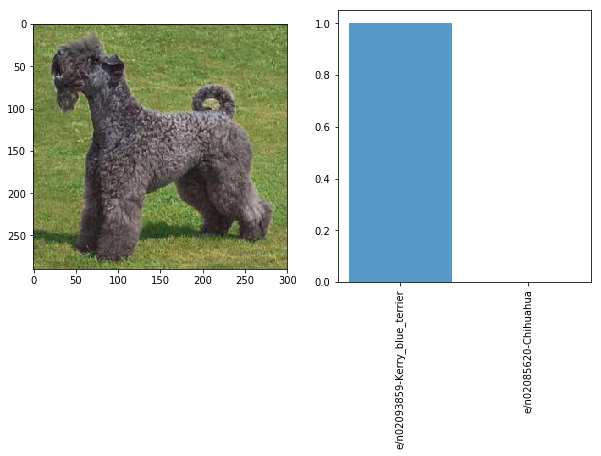

In [33]:
final_predict('../data/test/n02093859-Kerry_blue_terrier/3.jpg')